# XGBoost

In [13]:
from data.preprocessed_data import preprocessed_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report,  confusion_matrix
from bayes_opt import BayesianOptimization
import xgboost
import matplotlib.pyplot as plt

## BayesianOptimization with StratifiedKFold

In [6]:
def test_xgb_kfold(data):
    def xgb_cv(
        max_depth,
        learning_rate,
        n_estimators,
        max_leaves
    ):
        model = xgboost.XGBClassifier(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            max_leaves=int(max_leaves),
            random_state=0
        )
        accs = []
        stratified_k_fold = StratifiedKFold(random_state=0, shuffle=True)
        for (train_index, test_index) in stratified_k_fold.split(data, data.Churn):
            temp = data.iloc[train_index]
            test = data.iloc[test_index]
            train, valid = train_test_split(temp, test_size=len(test)/len(temp))

            model.fit(
                train.drop(columns=['Churn']), train['Churn'],
                eval_set=[(valid.drop(columns=['Churn']), valid['Churn'])],
                verbose=0
            )

            accuracy = model.score(
                test.drop(columns=['Churn']), test['Churn'],
            )
            accs.append(accuracy)

        return sum(accs) / len(accs)

    pbounds = {
        'learning_rate': (0.0001, 0.5),
        'n_estimators': (50, 500),
        'max_depth': (3, 10),
        'max_leaves': (50, 500),
    }

    bayesian_optimization = BayesianOptimization(
        f=xgb_cv,
        pbounds=pbounds,
        verbose=-1,
        random_state=0,
    )

    bayesian_optimization.maximize(
        init_points=10,
        n_iter=50
    )

    best_params = bayesian_optimization.max.get('params')
    best_params.update({
        'max_depth': int(best_params.get('max_depth')),
        'n_estimators': int(best_params.get('n_estimators')),
        'max_leaves': int(best_params.get('max_leaves')),
    })
    print(best_params)
    print('='*100)
    reports = {}
    confusion_mt = {}

    stratified_k_fold = StratifiedKFold(random_state=0, shuffle=True)
    for i, (train_index, test_index) in enumerate(stratified_k_fold.split(data, data.Churn)):
        temp = data.iloc[train_index]
        test = data.iloc[test_index]
        train, valid = train_test_split(temp, test_size=len(test)/len(temp))
        xgb = xgboost.XGBClassifier(
            **best_params,
            random_state=0,
        )
        xgb.fit(
            train.drop(columns=['Churn']), train['Churn'],
            eval_set=[(valid.drop(columns=['Churn']), valid['Churn'])],
            verbose=0
        )
        xgb_predict = xgb.predict(test.drop(columns=['Churn']))
        acc = xgb.score(test.drop(columns=['Churn']), test['Churn'])

        confusion_matrix_result = confusion_matrix(
            np.where(test.Churn==0, 1, 0),
            np.where(xgb.predict(test.drop(columns=['Churn']))==0, 1, 0),
        )
        TP = confusion_matrix_result[0, 0]
        FN = confusion_matrix_result[0, 1]
        FP = confusion_matrix_result[1, 0]
        TN = confusion_matrix_result[1, 1]

        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        f1 = 2*precision*recall / (precision+recall)
        accuracy = (TP+TN) / (TP+TN+FP+FN)

        confusion_mt.update({
            f'fold: {i+1}': {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy,
            }
        })

        reports.update({
            f'fold: {i+1}':{
                classification_report(test['Churn'], xgb_predict)
            }
        })

    return confusion_mt, reports

In [2]:
data = pd.read_csv('./data/train.csv')

### 데이터셋 준비

In [5]:
# 1. 모든 Nan값 없앤 데이터
drop_na_data = preprocessed_data(data)
# 2. Nan을 해당 컬럼의 Median값으로 채움
fill_na_data = preprocessed_data(data, True)
# 3. 2번 데이터에 일부 연속형데이터를 범주형으로 변환
cat_data = preprocessed_data(data, is_fillna=True, con_to_cat=True)
# 4. 2번 데이터에 클러스터링을 통한 라벨 feature추가
cluster_data = preprocessed_data(data, is_fillna=True, clustering=True)


### 모델평가

In [7]:
results = {}
drop_na_confusion_mts, drop_na_reorts = test_xgb_kfold(drop_na_data)
fill_na_confusion_mts, fill_na_reorts = test_xgb_kfold(fill_na_data)
cat_data_confusion_mts, cat_data_reorts = test_xgb_kfold(cat_data)
cluster_confusion_mts, cluster_reorts = test_xgb_kfold(cluster_data)

results.update({
    'drop_na': (drop_na_confusion_mts, drop_na_reorts),
    'fill_na_median': (fill_na_confusion_mts, fill_na_reorts),
    'continus_to_cat': (cat_data_confusion_mts, cat_data_reorts),
    'clustering_label': (cluster_confusion_mts, cluster_reorts)
})

|   iter    |  target   | learni... | max_depth | max_le... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7054    | 0.2745    | 8.006     | 321.2     | 295.2     |
| 2         | 0.706     | 0.2119    | 7.521     | 246.9     | 451.3     |
| 3         | 0.6921    | 0.4818    | 5.684     | 406.3     | 288.0     |
| 4         | 0.7118    | 0.2841    | 9.479     | 81.97     | 89.21     |
| 5         | 0.7217    | 0.01021   | 8.828     | 400.2     | 441.5     |
| 6         | 0.6962    | 0.4893    | 8.594     | 257.7     | 401.2     |
| 7         | 0.7196    | 0.05923   | 7.479     | 114.5     | 475.1     |
| 8         | 0.7075    | 0.261     | 5.903     | 169.1     | 398.4     |
| 9         | 0.7074    | 0.2281    | 6.979     | 58.46     | 327.9     |
| 10        | 0.702     | 0.3061    | 7.319     | 474.7     | 356.8     |
| 11        | 0.6928    | 0.4966    | 7.081     | 400.5     | 477.3     |
| 12        | 0.7073    | 0.2277    | 

### 결과

In [8]:
for key, value in results.items():
    print('='*100)
    print('='*100)
    print(f"xgb result BayesianOptimization, 'StratifiedKFold, {key}")
    print('='*100)
    for fold, result in value[0].items():
        print(f'{fold}: {result}')

    print('='*100)

    for fold, result in value[1].items():
        print(f'{fold}')
        for r in result:
            print(r)
        print('='*100)

xgb result BayesianOptimization, 'StratifiedKFold, drop_na
fold: 1: {'precision': 0.5555555555555556, 'recall': 0.13513513513513514, 'f1': 0.2173913043478261, 'accuracy': 0.72143503165511}
fold: 2: {'precision': 0.5534246575342465, 'recall': 0.1418041418041418, 'f1': 0.2257613858619726, 'accuracy': 0.7215355240679329}
fold: 3: {'precision': 0.5545335085413929, 'recall': 0.14812214812214813, 'f1': 0.23379501385041548, 'accuracy': 0.7220100502512563}
fold: 4: {'precision': 0.5924855491329479, 'recall': 0.14391014391014392, 'f1': 0.23157300197684272, 'accuracy': 0.726532663316583}
fold: 5: {'precision': 0.5678851174934726, 'recall': 0.15268515268515268, 'f1': 0.2406639004149377, 'accuracy': 0.7241206030150754}
fold: 1
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      7102
           1       0.56      0.14      0.22      2849

    accuracy                           0.72      9951
   macro avg       0.64      0.55      0.52      9951
wei

#### Feature Importance


##### recall이 가장 높은 데이터의 Feature importance 확인

In [10]:
best_param = {'learning_rate': 0.1005721895883048, 'max_depth': 5, 'max_leaves': 494, 'n_estimators': 194}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

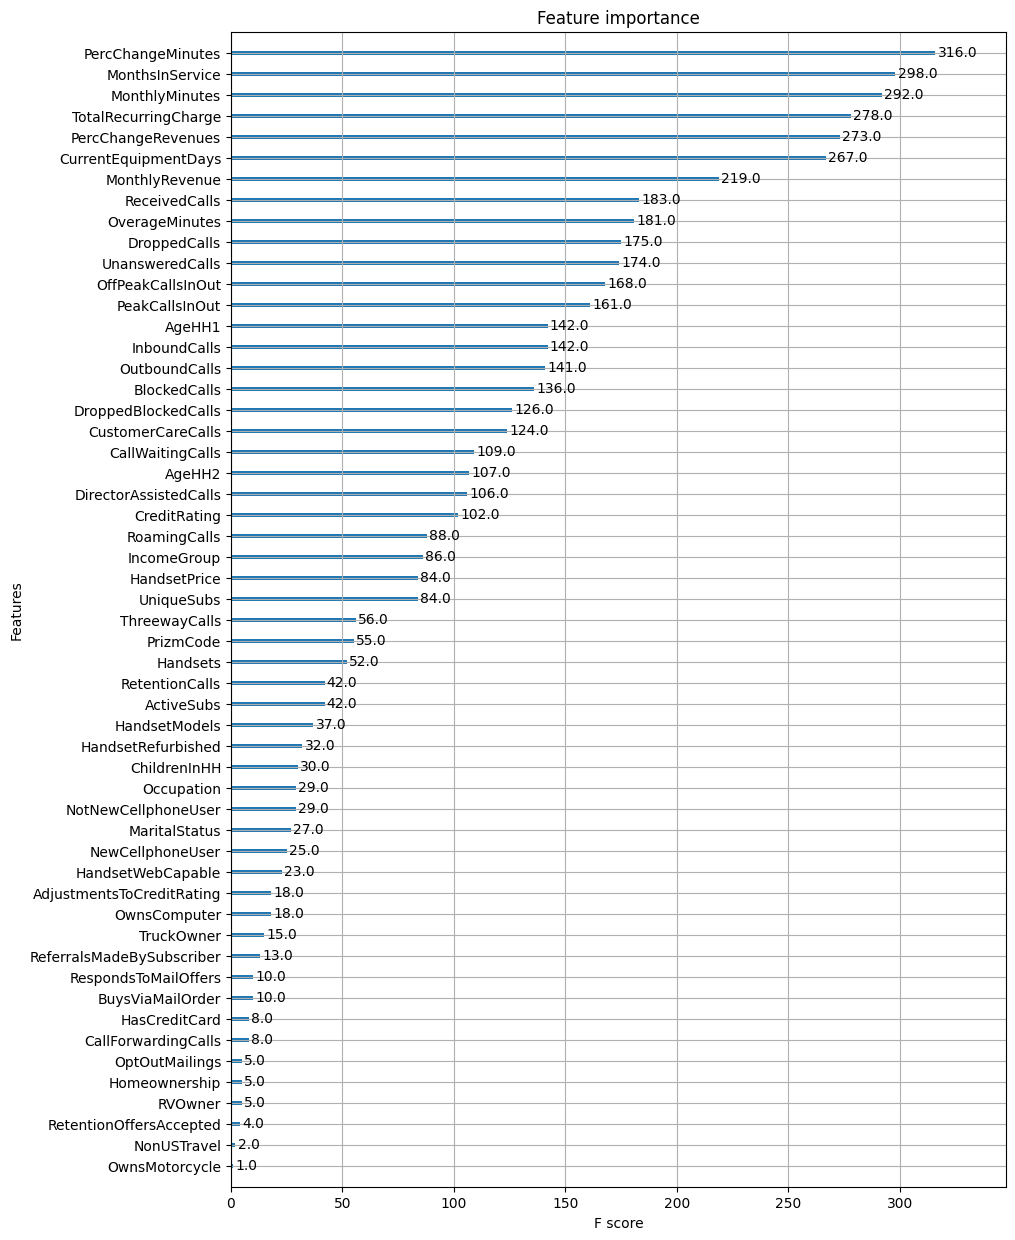

In [19]:
drop_na_train, temp = train_test_split(drop_na_data, test_size=0.4, random_state=0)
drop_na_valid, drop_na_test = train_test_split(temp, test_size=0.5, random_state=0)
xgb = xgboost.XGBClassifier(
            **best_param,
            random_state=0
        )
xgb.fit(
    drop_na_train.drop(columns=['Churn']), drop_na_train['Churn'],
    eval_set=[(drop_na_valid.drop(columns=['Churn']), drop_na_valid['Churn'])],
    verbose=0
)
plt.rcParams["figure.figsize"] = (10, 15)
xgboost.plot_importance(xgb)


##### 중요도가 낮은 Feature부터 하나씩 제거하면서 비교 

In [26]:
importance_data = pd.DataFrame({'importance':xgb.feature_importances_}, index = xgb.get_booster().feature_names)

In [30]:
importance_data = importance_data.sort_values('importance')


,importance
MadeCallToRetentionTeam,0.000000
AdjustmentsToCreditRating,0.007038
CallForwardingCalls,0.007716
Homeownership,0.010081
NonUSTravel,0.011628
NotNewCellphoneUser,0.012175
Handsets,0.012329
ThreewayCalls,0.012623
CallWaitingCalls,0.012639
DirectorAssistedCalls,0.013316


In [32]:
drop_na_train, temp = train_test_split(drop_na_data, test_size=0.4, random_state=0)
drop_na_valid, drop_na_test = train_test_split(temp, test_size=0.5, random_state=0)
max_drop_count = 20
results = {}
for i in range(0, max_drop_count):
    col = importance_data.iloc[:i, :].index

    xgb = xgboost.XGBClassifier(
                **best_param,
                random_state=0
            )
    xgb.fit(
        drop_na_train.drop(columns=['Churn']).drop(columns=col), drop_na_train['Churn'],
        eval_set=[(drop_na_valid.drop(columns=['Churn']).drop(columns=col), drop_na_valid['Churn'])],
        verbose=0
    )
    xgb_predict = xgb.predict(drop_na_test.drop(columns=['Churn']).drop(columns=col))
    results.update({
        f'drop {i+1} column':{
            classification_report(drop_na_test['Churn'], xgb_predict)
        }
    })

In [36]:
for i, result in results.items():
    print(i)
    for r in result:
        print(r)


drop 1 column
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      7126
           1       0.57      0.15      0.23      2825

    accuracy                           0.73      9951
   macro avg       0.65      0.55      0.53      9951
weighted avg       0.69      0.73      0.66      9951

drop 2 column
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      7126
           1       0.57      0.15      0.23      2825

    accuracy                           0.73      9951
   macro avg       0.65      0.55      0.53      9951
weighted avg       0.69      0.73      0.66      9951

drop 3 column
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      7126
           1       0.57      0.15      0.23      2825

    accuracy                           0.73      9951
   macro avg       0.66      0.55      0.53      9951
weighted avg       0.69      0.7